In [81]:
%matplotlib inline

import numpy as np
from numpy.fft import fft2

from sklearn_theano.feature_extraction import fetch_overfeat_weights_and_biases

from menpo.image import Image

from alaborticcv2015.deepconvkernel.pretrained import PreTrainedLDCN
from alaborticcv2015.deepconvkernel.loggabor import LogGaborLDCN 
from alaborticcv2015.utils import pad

In [45]:
def _compute_kernel1(filters, ext_shape=None):
    if len(filters) > 1:
        prev_kernel = _compute_kernel(filters[1:], ext_shape=ext_shape)
        kernel = 0
        for j, f in enumerate(filters[0]):
            if ext_shape is not None:
                f = pad(f, ext_shape=ext_shape)
            fft_f = fft2(f)
            kernel += fft_f.conj() * prev_kernel[j] * fft_f
    else:
        kernel = 0
        for f in filters[0]:
            if ext_shape is not None:
                f = pad(f, ext_shape=ext_shape)
            fft_f = fft2(f)
            kernel += fft_f.conj() * fft_f
    return np.real(kernel)

In [46]:
def _compute_kernel1_fast(filters, ext_shape=None):
    if len(filters) > 1:
        prev_kernel = _compute_kernel_fast(filters[1:], ext_shape=ext_shape)
        fs = filters[0]
        if ext_shape is not None:
            fs = pad(fs, ext_shape=ext_shape)
        fft_fs = fft2(fs)
        kernel = np.sum(fft_fs.conj() * prev_kernel[:, None, ...] * fft_fs, axis=0)
    else:
        fs = filters[0]
        if ext_shape is not None:
            fs = pad(fs, ext_shape=ext_shape)
        fft_fs = fft2(fs)
        kernel = np.sum(fft_fs.conj() * fft_fs, axis=0)
    return np.real(kernel)

In [73]:
def _compute_kernel2(filters, ext_shape=None):
    kernel = 1
    for fs in filters:
        k = 0
        for f in fs:
            if ext_shape is not None:
                f = pad(f, ext_shape)
            fft_f = fft2(f)
            k += np.sum(fft_f.conj() * fft_f, axis=0)
        kernel *= k
    return np.real(kernel)

In [89]:
def _compute_kernel2_fast(filters, ext_shape=None):
    kernel = 1
    for fs in filters:
        if ext_shape is not None:
            fs = pad(fs, ext_shape)
        fft_fs = fft2(fs)
        kernel *= np.sum(fft_fs.conj() * fft_fs, axis=(0, 1))
    return np.real(kernel)

In [67]:
def _compute_kernel3(self, level=None, ext_shape=None):
    kernel = 1
    for level_filters in self.filters[:level]:
        k = 0
        for f in level_filters:
            if ext_shape:
                f_pixels = pad(f.pixels, ext_shape, mode=self.padding)
            else:
                f_pixels = f.pixels
            fft_f = fft2(f_pixels)
            k += np.real(fft_f.conj() * fft_f)
        kernel *= k
    return Image(fftshift(kernel, axes=(-2, -1)))

IndentationError: expected an indented block (<ipython-input-67-14668a1491f3>, line 13)

In [83]:
color = False

if color:
    n_channels = 3
else:
    n_channels = 1

In [90]:
# weights, _ = fetch_overfeat_weights_and_biases(large_network=True)
# filters = [np.asarray(w) for w in weights]
# net = PreTrainedLDCN(filters[:2])

net = LogGaborLDCN()
net.build_network(n_channels=n_channels)

In [91]:
kernel = _compute_kernel2(net._filters, ext_shape=(50, 50))
kernel_fast = _compute_kernel2_fast(net._filters, ext_shape=(50, 50))

kernel == kernel_fast

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

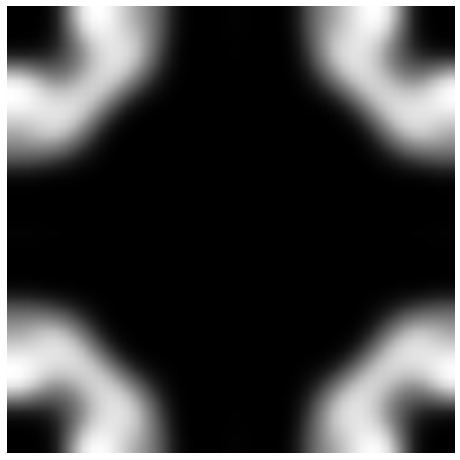

In [92]:
Image(kernel).view_widget()

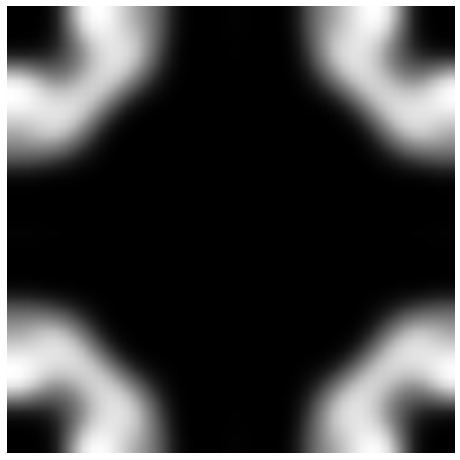

In [93]:
Image(kernel_fast).view_widget()

In [94]:
%timeit kernel = _compute_kernel2(net._filters)
%timeit kernel_fast = _compute_kernel2_fast(net._filters)

100 loops, best of 3: 3.38 ms per loop
1000 loops, best of 3: 543 µs per loop
